In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2021 - 2022 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Laura Murgatroyd (UKRI-STFC)
#                   Gemma Fardell (UKRI-STFC)       
#                   Jakob S. Jørgensen (DTU)

# Exercise 01 - Introduction to the Core Imaging Library (CIL) 

### 3D laboratory micro-CT, cone-beam data of sunflower seeds in an acrylic box

This exercise walks through the steps needed to load in a 3D cone-beam dataset of sunflower seeds in an acrylic box, acquired by laboratory micro-CT, and reconstruct it using FDK.
Here you will perform the same processing as the [01_intro_walnut_conebeam.ipynb](../01_intro_walnut_conebeam.ipynb) notebook, but on a Nikon dataset, instead of a Zeiss dataset.

Learning objectives:
- Load and investigate a Nikon data set.
- Apply CIL's `TransmissionAbsorptionConverter`.
- Compute FDK reconstruction using CIL.

This example requires the dataset `korn.zip` from https://zenodo.org/record/6874123#.Y0ghJUzMKUm :

- https://zenodo.org/record/6874123/files/korn.zip

If running locally please download the data and update the filepath in the `filename` variable below:

In [3]:
filename = "/mnt/share/materials/SIRF/Fully3D/CIL/Korn i kasse/47209 testscan korn01_recon.xtekct"

In [4]:
import os
from cil.io import NikonDataReader
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

## Exercise A: Loading Nikon Data and looking at the Geometry

1. Load the 3D cone-beam projection data of the seeds, using the `NikonDataReader`
2. `print` the data to get some basic information.
3. As well as the data itself, `AcquisitionData` contains geometric metadata in an `AcquisitionGeometry` object in the `geometry` field. `print` the geometry data.
4. Use the `show_geometry` method to display the scan set up visually.

*Note: This is a full 3D dataset so reading it from disk may take some time* 

The data is loaded in as a CIL `AcquisitionData` object. How many projections does this dataset contain and how many pixels do they have? Make sure to check the axis labels.

**Uncomment the following line and run the cell to see the solution, to run the lines you'll need to run the cell a second time**

Number of dimensions: 3
Shape: (1571, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -261.30649948,    0.        ]
	Rotation axis position: [0.45994612, 0.        , 0.        ]
	Rotation axis direction: [0.00172125, 0.        , 0.99999852]
	Detector position: [ -0.        , 850.41650052,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-9 in degrees: [180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762]
	Angles 1561-1570 in degrees: [-177.70847, -177.93762, -178.16678, -178.39594, -178.62509, -178.85

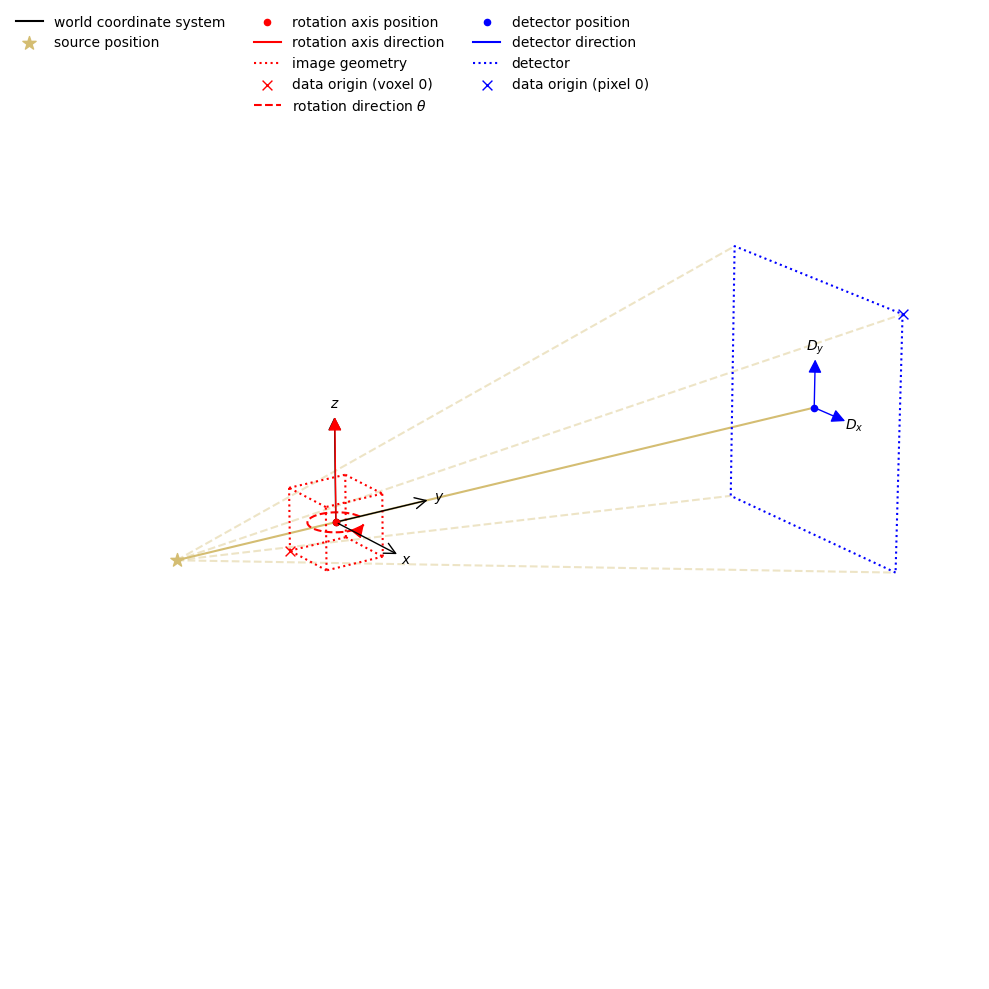

In [5]:
# read in the data from the Nikon `xtekct` file
data_in = NikonDataReader(file_name=filename).read()

# print the meta data associated with the data
print(data_in)

# print the geometry data associated with the data
print(data_in.geometry)

# display the geometry
show_geometry(data_in.geometry)

# We can see that this dataset contains 1571 projections each size 1000x1000 pixels.


## Exercise B: Displaying the Projections with islicer

Use `islicer` to display the projections.

Uncomment the following line and run the cell to see the solution, to run the lines you'll need to run the cell a second time:

In [6]:
islicer(data_in, direction='angle', size=10, origin='upper')


## Exercise C: Transmission to Absorption Conversion

You should have seen that the data is transmission data. We know this because the background value is 1.0. We need to apply the Beer–Lambert law to convert to the absorption data.

1. Use CIL's Transmission to Absorption processor to convert the data to absorption. 
2. Use `show2D` to look at the central `vertical` slice of the absorption data

Uncomment the following line and run the cell to see the solution, to run the lines you'll need to run the cell a second time:

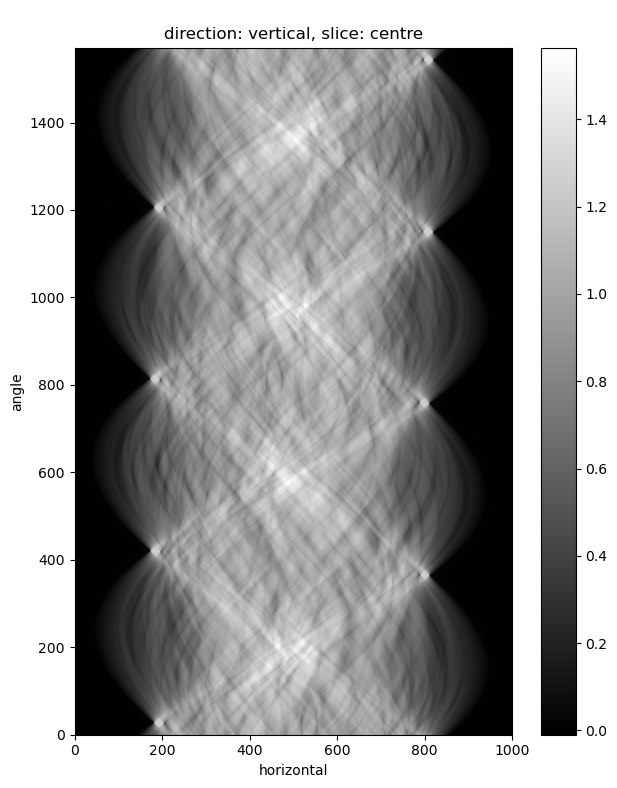

In [7]:
# calculate the absorption data using the Beer–Lambert law
data_absorption = TransmissionAbsorptionConverter()(data_in)

# show the centre slice using show2D
show2D(data_absorption, slice_list=('vertical', 'centre'))


## Exercise D: Reconstructing Cone Beam Data

We will use the FDK algorithm from CIL's recon module. FDK is filtered back-projection with special weights for cone-beam data. By default, the `recon` module uses TIGRE as a back-end.

1. Use `reorder` to ensure the data is in the correct format for `tigre`
2. Create and run the FDK algorithm.
3. Then show the reconstructed volume using `islicer`.

Uncomment the following line and run the cell to see the solution, to run the lines you'll need to run the cell a second time:

In [8]:
# reorder the data for the `tigre` backend
data_absorption.reorder(order='tigre')

# create a default image geometry to define the reconstruction volume
ig = data_absorption.geometry.get_ImageGeometry()

# create the FDK reconstructor
fdk =  FDK(data_absorption, ig)

# run the reconstructor
recon = fdk.run()

# visualise the 3D reconstructed volume
islicer(recon, direction='vertical', size=10) # change to 'horizontal_y' or 'horizontal_x' to view the data in other directions

FDK recon

Input Data:
	angle: 1571
	vertical: 1000
	horizontal: 1000

Reconstruction Volume:
	vertical: 1000
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



## Exercise E: Modifying the Reconstruction Volume

We can see that there is lots of empty space in the reconstruction. We could restrict the size of the image volume to remove this. Reconstructing empty voxels takes time so this is often an important step especially when you move on to iterative algorithms.

First, let's look at the current Image Geometry (you may need to change the variable names if you used different ones to the solutions):

In [9]:
print(data_absorption.geometry.get_ImageGeometry())

Number of channels: 1
channel_spacing: 1.0
voxel_num : x1000,y1000,z1000
voxel_size : x0.09401856379015312,y0.09401856379015312,z0.09401856379015312
center : x0,y0,z0



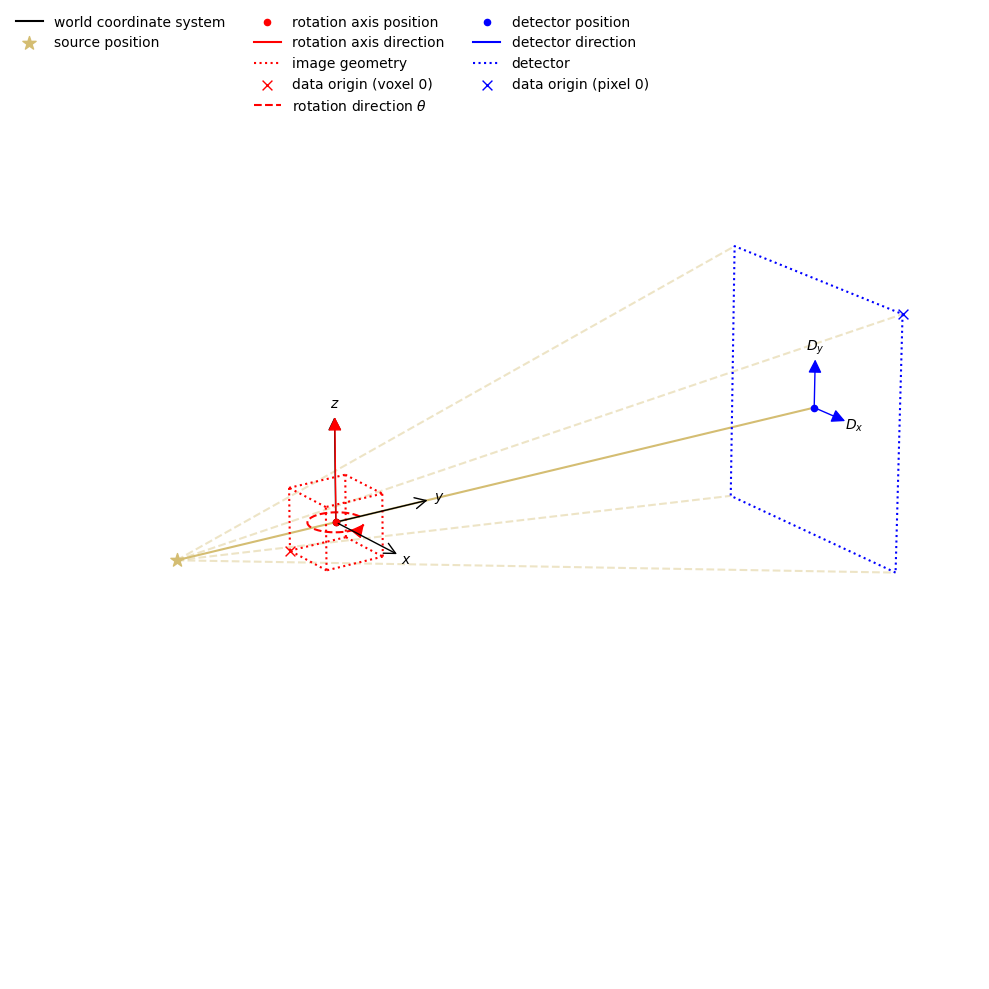

In [10]:
show_geometry(data_absorption.geometry, data_absorption.geometry.get_ImageGeometry())

Have a go at restricting the size of the image geometry to remove a significant amount of empty space from the reconstruction. Perform the reconstruction using your new image geometry, and display the result using `islicer`.

1. Create a default `ImageGeometry`
2. Modify the number of voxels to reconstruct
3. Create and run the FDK algorithm
4. Show the reconstructed volume using `islicer`

See [1_Introduction/00_CIL_geometry.ipynb](../00_CIL_geometry.ipynb), which should provide help in doing this.

Remember, you can check what your new geometry looks like by using `show_geometry`

Uncomment the following line and run the cell to see the solution, to run the lines you'll need to run the cell a second time:

Number of channels: 1
channel_spacing: 1.0
voxel_num : x700,y700,z700
voxel_size : x0.09401856379015312,y0.09401856379015312,z0.09401856379015312
center : x0,y0,z0



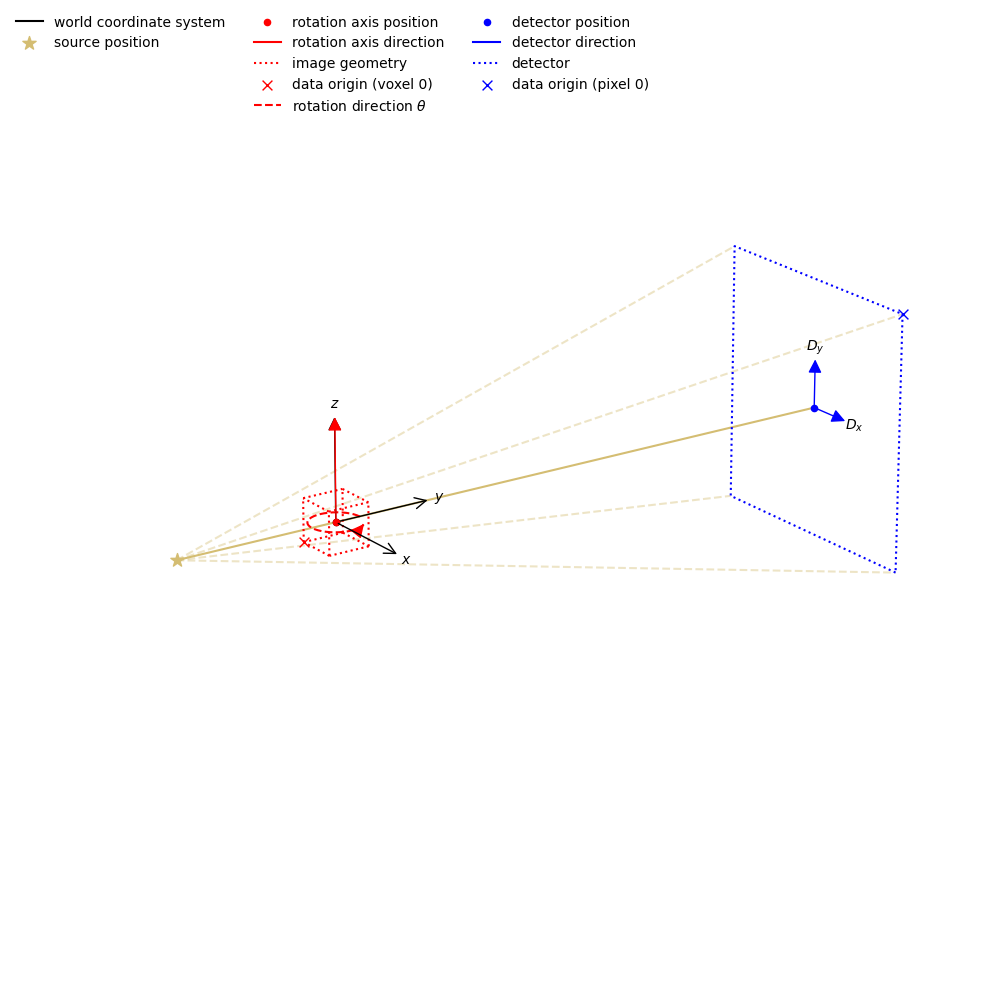

FDK recon

Input Data:
	angle: 1571
	vertical: 1000
	horizontal: 1000

Reconstruction Volume:
	vertical: 700
	horizontal_y: 700
	horizontal_x: 700

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



In [11]:
# get the default image geometry
cropped_ig = data_absorption.geometry.get_ImageGeometry()

# modify the number of voxels in X, Y and Z 
cropped_ig.voxel_num_x = 700
cropped_ig.voxel_num_y = 700
cropped_ig.voxel_num_z = 700
print(cropped_ig)

# show the the geometry
show_geometry(data_absorption.geometry, cropped_ig)

# ensure our data is configured for `tigre`
data_absorption.reorder(order='tigre')

# create an FDK algorithm with the new geometry
fdk =  FDK(data_absorption, cropped_ig)

#run the algorithm to get the reconstruction
recon = fdk.run()

#visualise the reconstruction using islicer
islicer(recon, direction='vertical', size=10) # change to 'horizontal_y' or 'horizontal_x' to view the data in other directions